##**Automobile Loan Default Prediction: Developing a Model to Identify High-Risk Borrowers**


### Load the Dataset & Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
orig_data = pd.read_csv('/content/Train_Dataset.csv')

<ipython-input-2-e539fd1da47f>:1: DtypeWarning: Columns (1,7,8,16,17,18,19,20,35) have mixed types. Specify dtype option on import or set low_memory=False.
  orig_data = pd.read_csv('/content/Train_Dataset.csv')


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width',None)
pd.set_option('display.max_rows',None)

In [ ]:
orig_data.head(10)

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,12142509,6750,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,13957,1062,6123,383,NaN,1,1,0,Sales,2.0,2.0,6.0,17.0,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
1,12138936,20250,1.0,0.0,1.0,NaN,0.0,15282,1826.55,Alone,Service,Graduation,M,Male,CL,Home,0.008575,14162,4129,7833,21,0.0,1,0,1,NaN,2.0,2.0,3.0,10.0,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0
2,12181264,18000,0.0,0.0,1.0,0.0,1.0,59527.35,2788.2,Alone,Service,Graduation dropout,W,Male,CL,Family,0.0228,16790,5102,NaN,331,NaN,1,0,0,Realty agents,2.0,2.0,4.0,NaN,Yes,Yes,Self-employed,NaN,0.552795,0.329655,0.0742,277.0,0.0,0
3,12188929,15750,0.0,0.0,1.0,1.0,0.0,53870.4,2295.45,Alone,Retired,Secondary,M,Male,CL,Home,0.010556,23195,365243,NaN,775,NaN,1,0,0,NaN,2.0,3.0,2.0,15.0,Yes,Yes,XNA,NaN,0.135182,0.631355,NaN,1700.0,3.0,0
4,12133385,33750,1.0,0.0,1.0,0.0,2.0,133988.4,3547.35,Alone,Commercial,Secondary,M,Female,CL,Home,0.020713,11366,2977,5516,4043,6.0,1,0,0,Laborers,4.0,1.0,3.0,NaN,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355639,0.2021,674.0,1.0,0
5,12191614,11250,0.0,1.0,1.0,1.0,1.0,13752,653.85,Alone,Service,Secondary,W,Female,CL,Home,0.019101,13881,1184,3910,3910,NaN,1,0,0,Laborers,2.0,2.0,2.0,10.0,Yes,Yes,Other,NaN,0.697928,0.420611,0.0639,739.0,0.0,0
6,12128086,15750,1.0,1.0,0.0,1.0,0.0,128835,3779.55,Alone,Retired,Secondary,S,Male,CL,Home,0.016612,21323,365243,113,4855,10.0,1,0,0,NaN,1.0,2.0,3.0,14.0,Yes,Yes,XNA,0.729913,0.602545,0.511892,0.2041,0.0,3.0,0
7,12215264,13500,0.0,0.0,1.0,1.0,0.0,60415.2,3097.8,Alone,Retired,Secondary,M,Male,CL,Home,0.009175,22493,365243,12617,5280,NaN,1,0,1,NaN,2.0,2.0,4.0,15.0,Yes,Yes,XNA,0.711468,0.657508,0.549597,NaN,1687.0,4.0,0
8,12159147,13500,1.0,1.0,0.0,1.0,1.0,45000,1200.15,Relative,Commercial,Graduation,M,Female,CL,Home,0.006008,NaN,7889,5455,2665,14.0,1,0,1,Sales,3.0,2.0,4.0,13.0,Yes,Yes,Self-employed,0.475727,0.637594,0.553165,0.1670,1611.0,0.0,0
9,12130547,12150,0.0,0.0,0.0,1.0,0.0,16320.15,1294.65,Alone,Retired,Secondary,W,Male,CL,Home,0.016612,20507,365243,2834,4053,NaN,1,0,0,NaN,1.0,2.0,NaN,9.0,Yes,Yes,XNA,0.682285,0.063343,0.08065,NaN,533.0,5.0,0


In [ ]:
# creating a copy and then removing the ID column which is not necessary for analysis

df = orig_data.copy()
df = df.drop('ID', axis = 1)

In [ ]:
# certain columns within the dataset are mixed datatypes which can affect our analysis so removing them is the next step

columns_to_convert = ['Client_Income','Credit_Amount', 'Loan_Annuity', 'Population_Region_Relative',
                      'Age_Days', 'Employed_Days', 'Registration_Days', 'ID_Days', 'Score_Source_3']

# Replace the string values '#VALUE!' and '$' with NaN
df[columns_to_convert] = df[columns_to_convert].replace(['#VALUE!', '$','@','#','x','&','m'], np.nan)

# Convert the columns to float data type
df[columns_to_convert] = df[columns_to_convert].astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121856 entries, 0 to 121855
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Client_Income               118234 non-null  float64
 1   Car_Owned                   118275 non-null  float64
 2   Bike_Owned                  118232 non-null  float64
 3   Active_Loan                 118221 non-null  float64
 4   House_Own                   118195 non-null  float64
 5   Child_Count                 118218 non-null  float64
 6   Credit_Amount               118219 non-null  float64
 7   Loan_Annuity                117030 non-null  float64
 8   Accompany_Client            120110 non-null  object 
 9   Client_Income_Type          118155 non-null  object 
 10  Client_Education            118211 non-null  object 
 11  Client_Marital_Status       118383 non-null  object 
 12  Client_Gender               119443 non-null  object 
 13  Loan_Contract_

In [ ]:
# Number of numerical columns & Number of categorical columns in the DataFrame

numerical_columns = df.select_dtypes(include=['float', 'int']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

print(f"Number of Numerical Columns: {len(numerical_columns)}")
print(f"Number of Categorical Columns: {len(categorical_columns)}")

Number of Numerical Columns: 28
Number of Categorical Columns: 11


## **Exploratory Data Analysis**

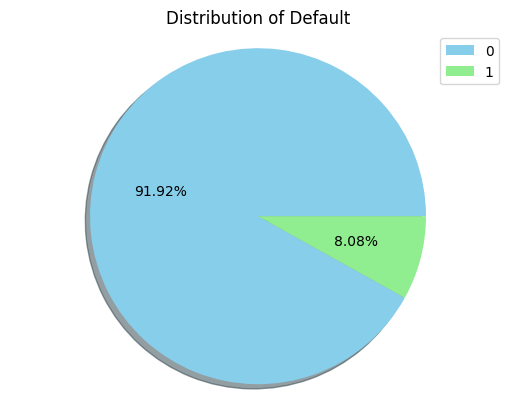

In [ ]:
count = df['Default'].value_counts().tolist()
labels = df['Default'].value_counts().index.tolist()
plt.pie(count, autopct='%.2f%%', colors=['skyblue', 'lightgreen'], shadow=True)
plt.legend(labels,loc = 'best')
plt.title('Distribution of Default')
plt.axis('equal')

plt.show()

Unbalanced distribution with 8.08% defaults and 91.92% no defaults, so a Model which predicts no default for all records will have 92% accuracy

## **Univariate Analysis**

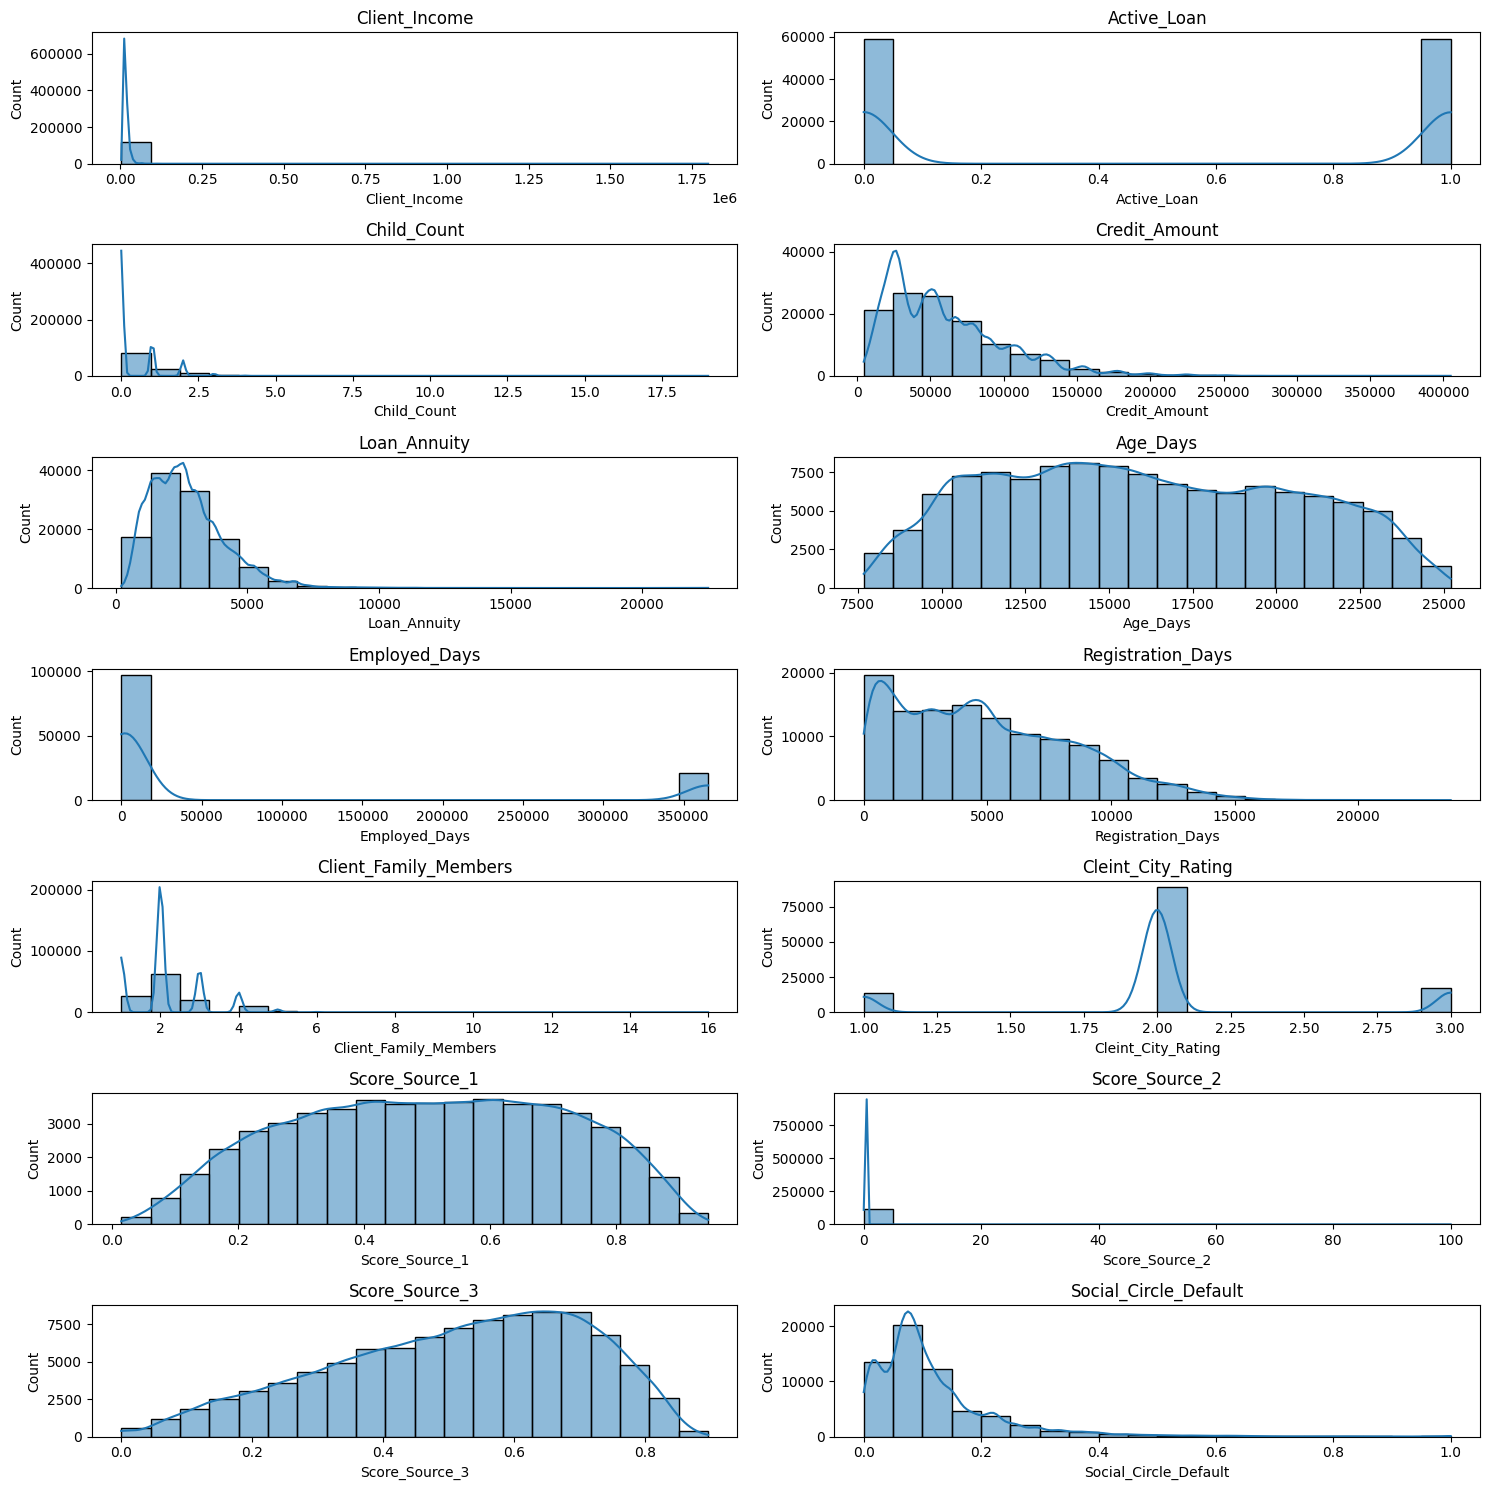

In [ ]:
#Select numerical columns for univariate analysis
numerical_columns = ['Client_Income', 'Active_Loan', 'Child_Count', 'Credit_Amount', 'Loan_Annuity',
                     'Age_Days', 'Employed_Days', 'Registration_Days', 'Client_Family_Members',
                     'Cleint_City_Rating', 'Score_Source_1', 'Score_Source_2', 'Score_Source_3','Social_Circle_Default']

# Plot histograms for numerical variables
plt.figure(figsize=(15,15))
for i, column in enumerate(numerical_columns):
    plt.subplot(7, 2, i + 1)
    sns.histplot(df[column], kde=True, bins=20)
    plt.title(column)
plt.tight_layout()
plt.show()

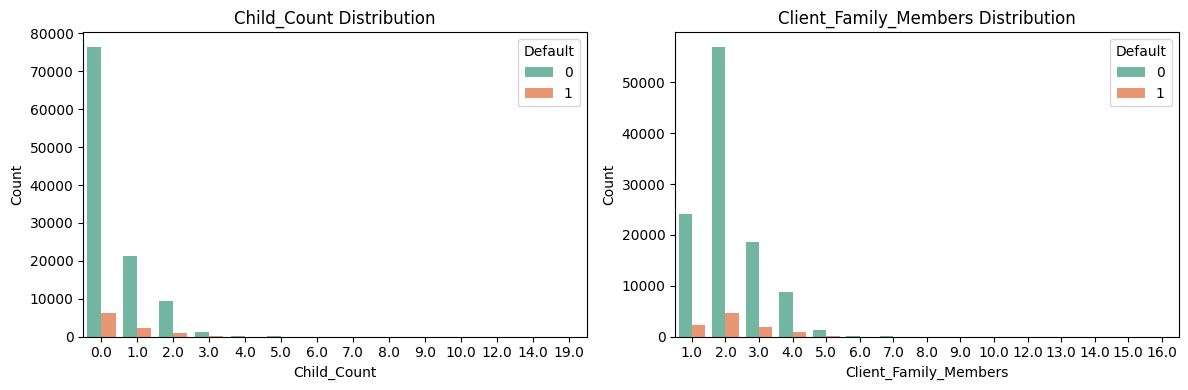

In [ ]:
# Create a grid of plots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loop through the columns and create count plots side by side
for col_idx, column in enumerate(["Child_Count", "Client_Family_Members"]):
    sns.countplot(data=df, x=column, hue="Default", ax=axes[col_idx], palette="Set2")
    axes[col_idx].set_xlabel(column)
    axes[col_idx].set_ylabel("Count")
    axes[col_idx].set_title(f"{column} Distribution")

# Adjust the layout for better readability
plt.tight_layout()
plt.show()

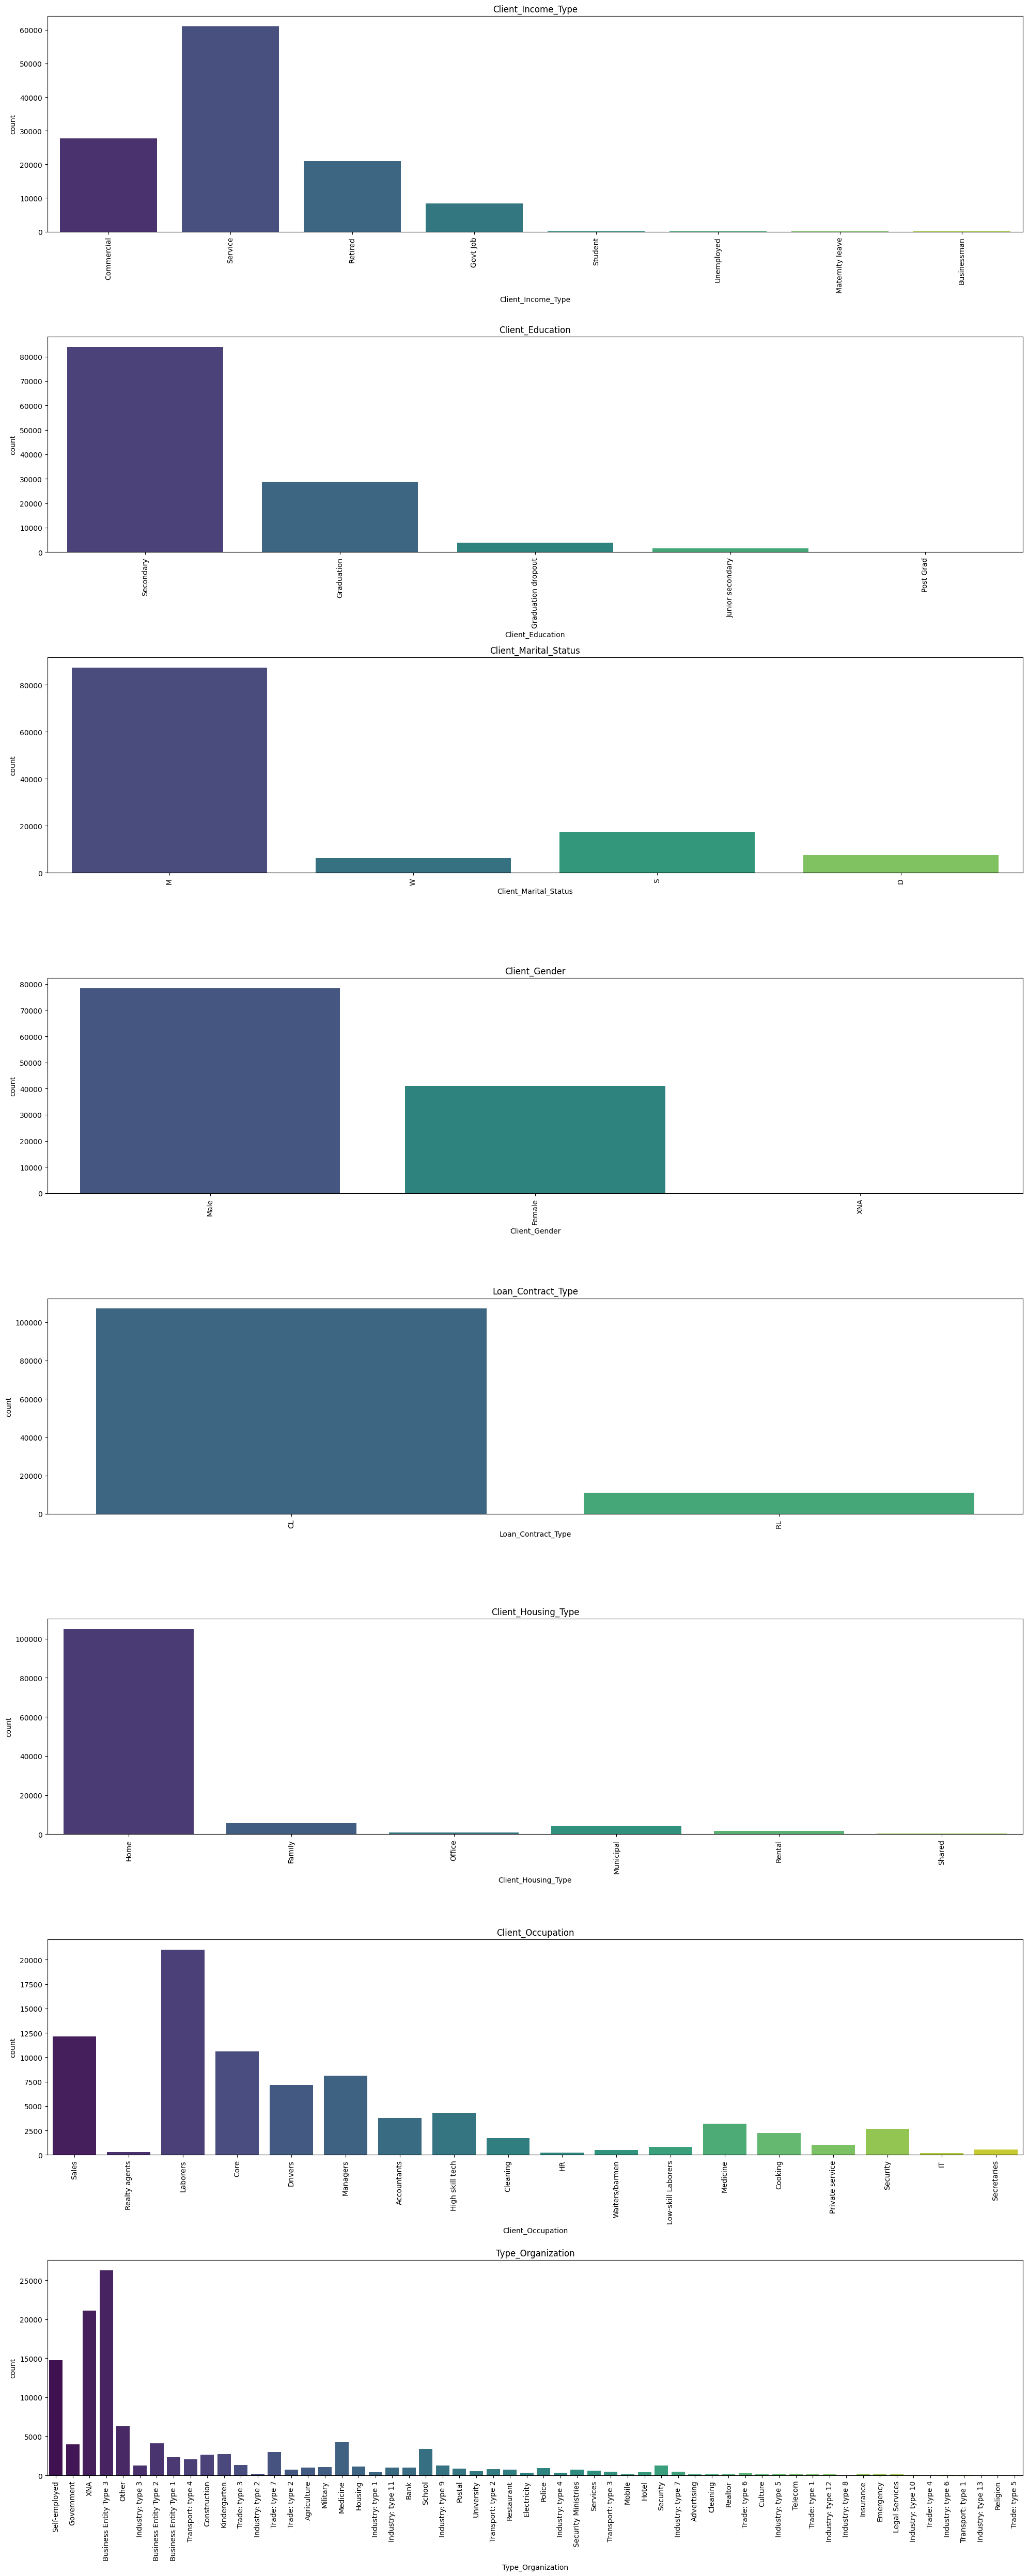

In [ ]:
# Select categorical columns for univariate analysis
categorical_columns = ['Client_Income_Type', 'Client_Education', 'Client_Marital_Status', 'Client_Gender',
                       'Loan_Contract_Type', 'Client_Housing_Type', 'Client_Occupation', 'Type_Organization']

# Plot count plots for categorical variables
plt.figure(figsize=(20, 50))
for i, column in enumerate(categorical_columns):
    plt.subplot(8, 1, i + 1)
    sns.countplot(data=df, x=column, palette='viridis')
    plt.title(column)
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

  ### **Insights from Numerical Columns Univariate Analysis:**

 Client_Income: The distribution of client income is right-skewed, indicating that a majority of clients have lower                    incomes.
    
Active_Loan: Most clients have an active loan, as indicated by a spike in the "1" category. The distribution is imbalanced.
    
Child_Count: The majority of clients have no children, with a few having one or more children.

Credit_Amount: The distribution of credit amounts is heavily right-skewed, indicating a higher concentration of lower credit amounts.
    
Loan_Annuity: The distribution of loan annuities appears to be right-skewed, with higher annuities being less                       frequent.
    
Age_Days: The distribution of client age in days shows a somewhat uniform distribution.

Employed_Days: The distribution of days employed by clients is right-skewed, with a concentration of clients                          employed for fewer days.
    
Registration_Days: The distribution of registration days shows a similar pattern to the Employed_Days variable.

Client_Family_Members: The majority of clients have 1 or 2 family members, with a few having more.
    
Cleint_City_Rating: The majority of clients have a city rating around 2.0 to 2.5, with fewer clients having lower                         or higher ratings.
    
Score_Source_1, Score_Source_2, Score_Source_3: These variables have similar distributions, but Score Source 3 is more variable than the other two sources. Score Source 1 is the most popular scoring source.

### **Insights from Categorical Columns Univariate Analysis:**

Client_Income_Type: Most clients have income from "Working" or "Commercial associate" sources.

Client_Education: A significant number of clients have completed Secondary / secondary special education, followed by Higher education.

Client_Marital_Status: The majority of clients are married or single.
Client_Gender: There are more female clients than male clients.

Loan_Contract_Type: Most loans have a "Cash loans" contract type, with fewer "Revolving loans."

Client_Housing_Type: A significant number of clients live in House/apartment housing type.

Client_Occupation: The majority of clients have "Laborers" as their occupation.

Type_Organization: Most clients are associated with "Business Entity Type 3" or "Self-employed" organizations.

## **Bivariate Analysis**

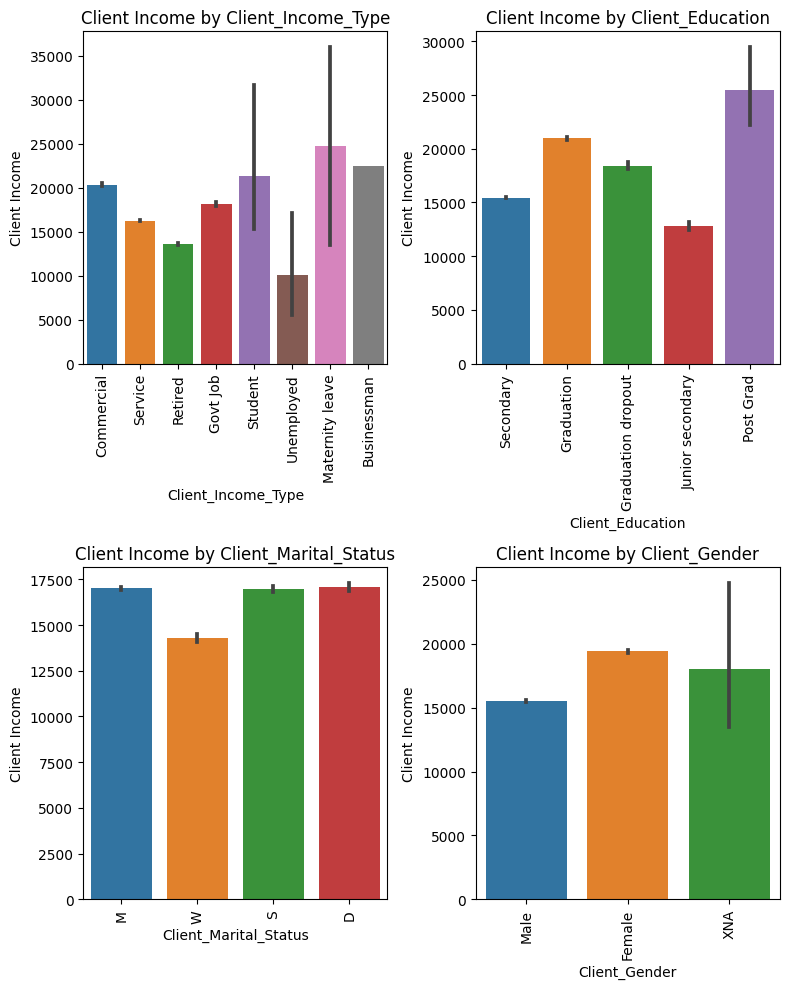

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10))
category = ['Client_Income_Type', 'Client_Education', 'Client_Marital_Status', 'Client_Gender']

axes = axes.flatten()

for i, cols in enumerate(category):
    sns.barplot(x=cols, y='Client_Income', data=df, ax=axes[i])
    axes[i].set_title('Client Income by {}'.format(cols))
    axes[i].set_xlabel(cols)
    axes[i].set_ylabel('Client Income')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)


for ax in axes[len(category):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Insights
Client_Income_Type: Maternity_leave tends to be oh higher average income but with large variation between minimum and maximum values. Unemployed has the lowest average income.
Client_education: Clients with postgraduation tends to have higher average income while junior_secondnary education has the lowest Average_Income.
Client_gender- Female clients have higher average income.


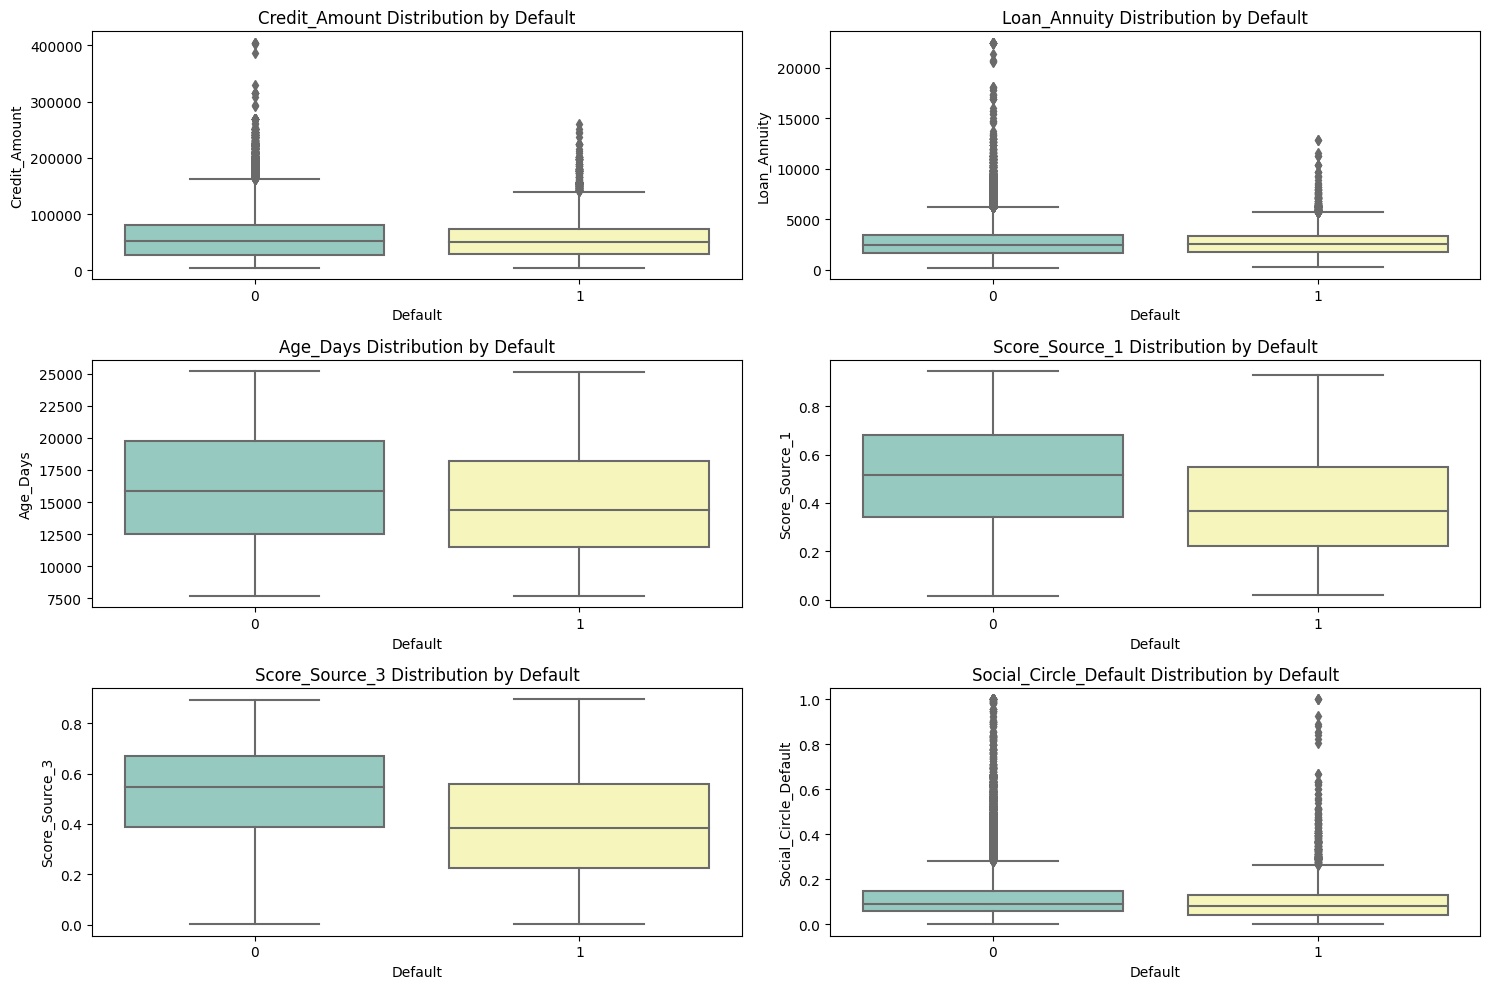

In [ ]:
numerical_columns = ['Credit_Amount', 'Loan_Annuity', 'Age_Days', 'Score_Source_1', 'Score_Source_3', 'Social_Circle_Default']
num_cols_per_row = 2
num_rows = (len(numerical_columns) + num_cols_per_row - 1) // num_cols_per_row

fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(15, 10))

for idx, col in enumerate(numerical_columns):
    row = idx // num_cols_per_row
    col_idx = idx % num_cols_per_row
    sns.boxplot(x='Default', y=col, palette='Set3', data=df, ax=axes[row, col_idx])
    axes[row, col_idx].set_xlabel('Default')
    axes[row, col_idx].set_ylabel(col)
    axes[row, col_idx].set_title(f'{col} Distribution by Default')

# Remove any empty subplots
if len(numerical_columns) < num_rows * num_cols_per_row:
    for idx in range(len(numerical_columns), num_rows * num_cols_per_row):
        fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()

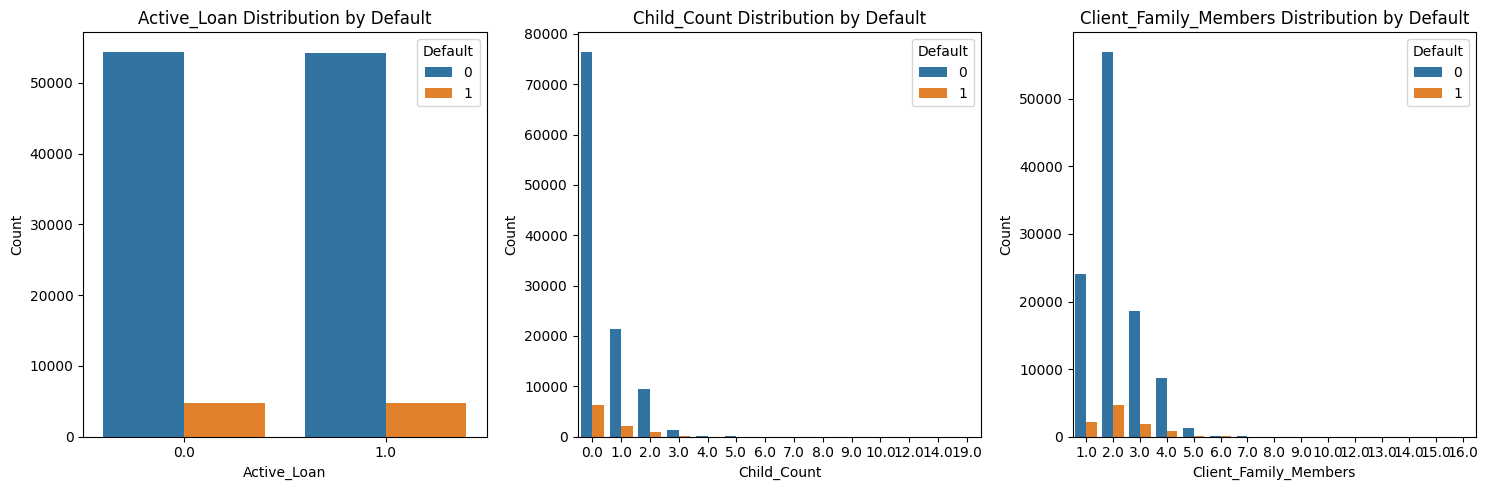

In [ ]:
# Create a grid of plots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the columns and create side-by-side countplots
for col_idx, column in enumerate(["Active_Loan", "Child_Count", "Client_Family_Members"]):
    sns.countplot(data=df, x=column, hue="Default", ax=axes[col_idx])
    axes[col_idx].set_xlabel(column)
    axes[col_idx].set_ylabel("Count")
    axes[col_idx].set_title(f"{column} Distribution by Default")

# Adjust the layout for better readability
plt.tight_layout()
plt.show()

## **Insights**

Active_Loan Distribution by Default:
Clients who have an active loan are more likely to default on their loans compared to those without an active loan. This suggests that having multiple ongoing loans might increase the risk of defaulting.

Child_Count Distribution by Default:
The number of children a client has does not seem to have a strong impact on the likelihood of default. The distribution of defaulters and non-defaulters appears to be relatively similar across different child count categories.

Credit_Amount Distribution by Default:
Clients who have taken larger credit amounts are more likely to default. This is consistent with the intuition that larger loans represent higher financial obligations, and clients might struggle to repay them.

Loan_Annuity Distribution by Default:
Clients with higher loan annuity payments have a higher probability of defaulting. Higher annuity payments indicate larger monthly loan obligations, and clients may find it challenging to manage such high payments consistently.

Age_Days Distribution by Default:
The Age_Days variable could be a useful predictor of whether a client is likely to default on a loan payment. Clients who are younger or older than the majority may be more likely to default.

Client_Family_Members Distribution by Default:
In "Client_Family_Members" feature, Clients who have more family members by default may be more likely to default, as they may have more financial obligations or may be more likely to be exposed to financial hardship.

Score_Source_1 Distribution by Default:
Clients with Source Score 1 increases, the likelihood of default increases. It suggests that "Score_Source_1" (which likely represents a credit score or risk assessment) is a useful predictor of loan default, with higher scores indicating higher credit risk.

Score_Source_3 Distribution by Default:
Clients with higher values of "Score_Source_3" are more likely to default. Similar to "Score_Source_1," "Score_Source_3" seems to be another relevant predictor of default behavior, with higher scores indicating higher credit risk.

Social_Circle_Default Distribution by Default:
The "Social_Circle_Default" feature  useful predictor of whether a client is likely to default on a loan payment.

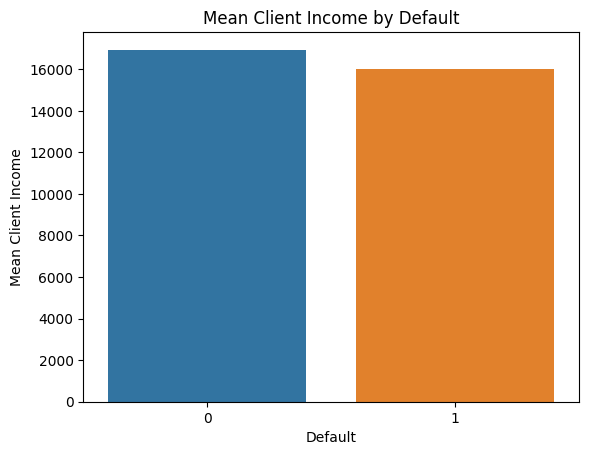

In [ ]:
# Assuming 'df' is your DataFrame containing the 'Default' and 'Client_Income' columns.
grouped_data = df.groupby('Default')['Client_Income'].mean().reset_index()

# Create bar plot
sns.barplot(x='Default', y='Client_Income', data=grouped_data)

# Set plot title and labels
plt.title('Mean Client Income by Default')
plt.xlabel('Default')
plt.ylabel('Mean Client Income')

plt.show()

## **Insight**

Default vs. Mean Client Income: The plot displays two bars representing the mean client income for two categories of 'Default' (1 for default, 0 for non-default). The x-axis represents the 'Default' category, and the y-axis represents the mean client income.

Difference in Mean Income: The bar for 'Default=0' (non-default) is higher than the bar for 'Default=1' (default). This indicates that, on average, clients who do not default have a higher mean income compared to clients who default.

Impact of Default on Income: The plot suggests that defaulting behavior is associated with lower mean client income. This may indicate that clients with lower income levels are more likely to default on their obligations.

Contrast in Mean Income: The contrast between the two bars indicates a difference in mean income between the two groups. This difference can be important for assessing the potential risk of default based on client income.

Overall, the bar plot allows us to compare the mean client income for default and non-default groups, providing insights into the relationship between default behavior and income levels. It appears that there is a notable difference in mean income between the two groups, and clients with lower income may have a higher likelihood of defaulting.

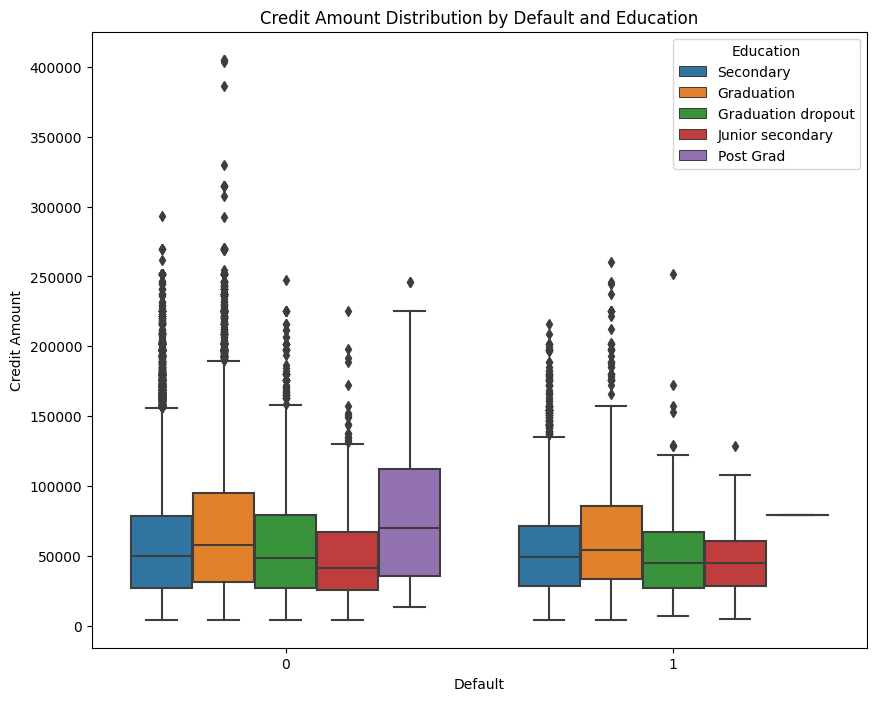

In [ ]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='Default', y='Credit_Amount', hue='Client_Education', data=df)
plt.xlabel('Default')
plt.ylabel('Credit Amount')
plt.title('Credit Amount Distribution by Default and Education')
plt.legend(title='Education')
plt.show()

From the box plot:

Credit Amount Distribution: The box plot shows the distribution of Credit Amount for different values of 'Default' (1 for default, 0 for non-default). The box represents the interquartile range (IQR) of the data, with the middle line representing the median. The whiskers extend to the minimum and maximum values within 1.5 times the IQR. Any data points beyond the whiskers are considered outliers.

Default vs. Non-Default: The box plots are divided into two categories based on 'Default'. The box plot for 'Default=0' (non-default) shows a higher median Credit Amount compared to 'Default=1' (default). This suggests that clients who do not default tend to have higher Credit Amounts.

Education Impact: The box plots are further divided by 'Client_Education', indicated by different colors. The plots allow us to compare the Credit Amount distribution for different levels of education within each 'Default' category.

Education and Default Relationship: The plot shows that in both 'Default=0' and 'Default=1' groups, the median Credit Amount is generally higher for clients with higher education levels (e.g., Graduate, Post Graduate) compared to those with lower education levels (e.g., Secondary, Primary).

Spread of Data: The box plots provide information about the spread of Credit Amount data. The larger the box, the higher the variability in the data within that category. For instance, the 'Default=0' box for 'Graduate' education has a larger spread than the 'Default=0' box for 'Primary' education, indicating more variation in Credit Amount for graduates who do not default.

Outliers: The plot displays individual data points beyond the whiskers, which are considered outliers. These outliers represent extreme values of Credit Amount for specific combinations of 'Default' and 'Client_Education'.

Insights:

Clients with higher education levels tend to have higher Credit Amounts, regardless of whether they default or not.
Non-defaulted clients generally have higher median Credit Amounts compared to defaulted clients.
Education level can be an important factor in understanding Credit Amount and its association with defaulting behavior.
Keep in mind that these insights are based on the analysis of the box plot and provide a general understanding of the data.

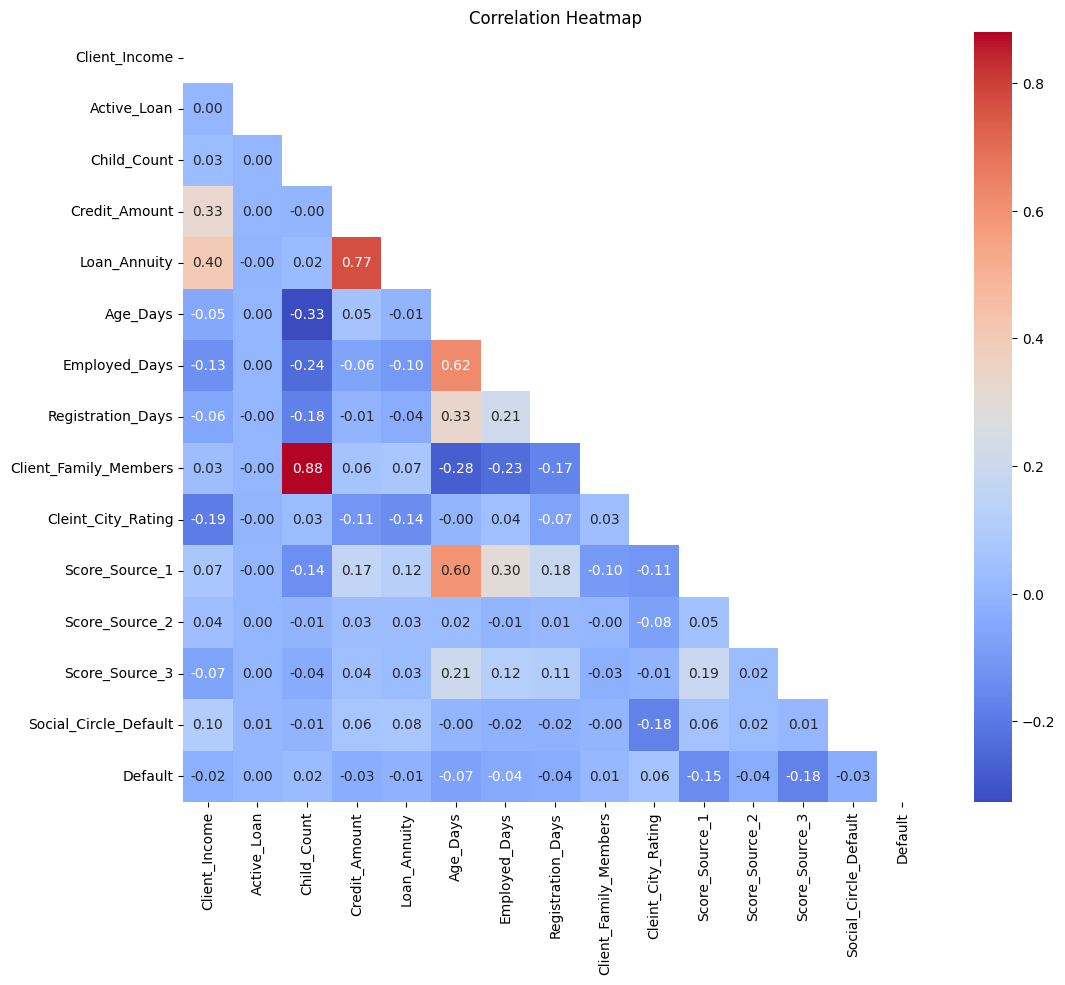

In [ ]:
numerical_columns_with_default = ['Client_Income', 'Active_Loan', 'Child_Count', 'Credit_Amount', 'Loan_Annuity', 'Age_Days', 'Employed_Days', 'Registration_Days', 'Client_Family_Members', 'Cleint_City_Rating', 'Score_Source_1', 'Score_Source_2', 'Score_Source_3', 'Social_Circle_Default', 'Default']

corr_matrix = df[numerical_columns_with_default].corr()
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

### **Insights**

Correlation heatmap for the numerical columns in the DataFrame 'df' with respect to the 'Default' column. Let's interpret the insights from the heatmap:

Correlation Strength: The heatmap uses colors to represent the strength of the correlation between pairs of variables. Positive correlations are shown in warmer colors (reds), while negative correlations are shown in cooler colors (blues). The intensity of the color indicates the magnitude of the correlation, with darker colors representing stronger correlations.

Default Correlation: The rightmost column of the heatmap shows the correlation coefficients between each numerical column and the 'Default' column. This provides insights into how each numerical feature relates to the target variable ('Default'). Positive correlations suggest that the feature has a positive impact on the likelihood of default, while negative correlations indicate a negative impact.

Correlation Strength Between Numerical Features: The heatmap reveals the relationships between the numerical features themselves. Features with strong positive correlations (e.g., 'Credit_Amount' and 'Loan_Annuity') or strong negative correlations (e.g., 'Age_Days' and 'Employed_Days') may indicate multicollinearity between these features.

Multicollinearity: When two or more features are highly correlated, it may indicate multicollinearity, which can affect the performance of some machine learning algorithms. Detecting multicollinearity is crucial when building predictive models.

Interpretation: Examine the magnitude and direction of correlations to understand how numerical features are related to each other and to the target variable ('Default'). Positive correlations between certain features and 'Default' may suggest higher risk factors, while negative correlations might indicate protective factors against default.



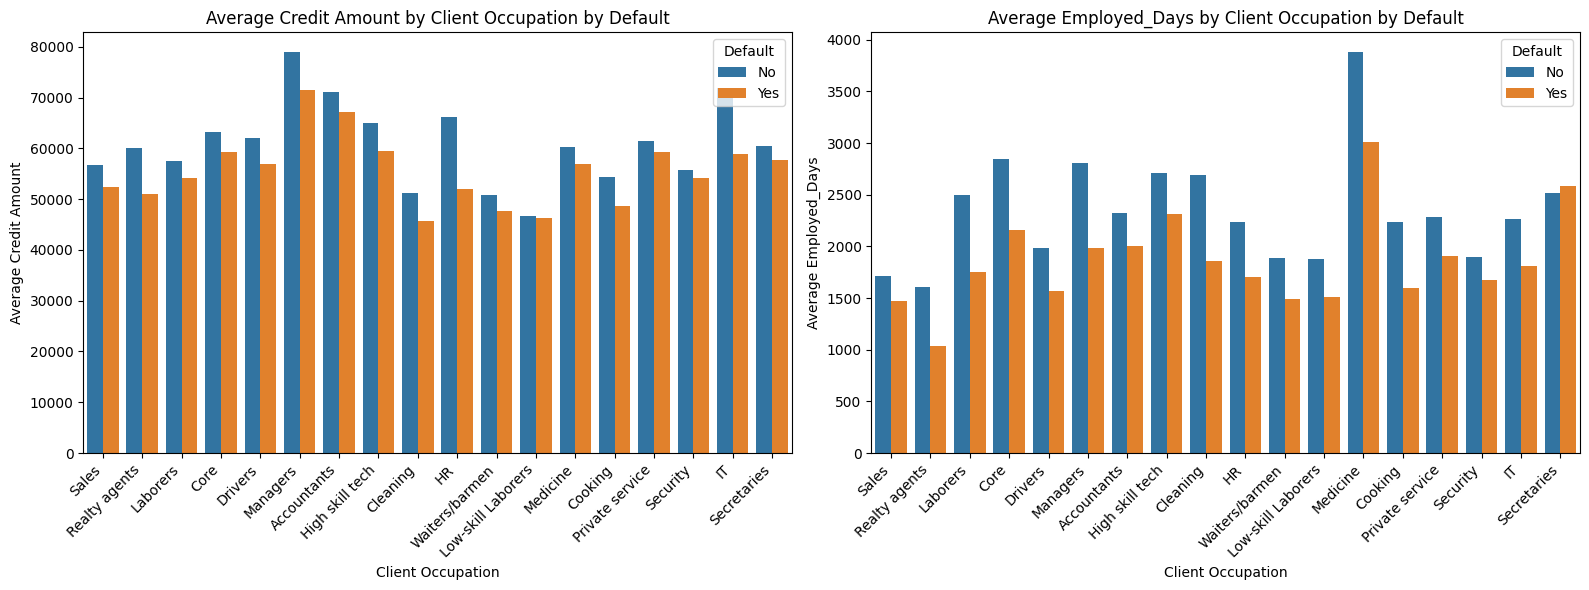

In [ ]:
# Calculate the mean Credit_Amount for each Client Occupation
occupation_credit_mean = df.groupby('Client_Occupation')['Credit_Amount'].mean()

# Sort the occupations based on mean Credit_Amount
sorted_occupations = occupation_credit_mean.sort_values().index

# Create a figure with two subplots
plt.figure(figsize=(16, 6))

# Subplot 1: Average Credit Amount by Client Occupation by Default
plt.subplot(1, 2, 1)
sns.barplot(x='Client_Occupation', y='Credit_Amount', hue='Default', data=df, estimator=lambda x: x.mean(),errorbar=None)
plt.xlabel('Client Occupation')
plt.ylabel('Average Credit Amount')
plt.title('Average Credit Amount by Client Occupation by Default')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Default', loc='upper right', labels=['No', 'Yes'])

# Calculate the mean Employed_Days for each Client Occupation
occupation_employed_days_mean = df.groupby('Client_Occupation')['Employed_Days'].mean()

# Sort the occupations based on mean Employed_Days
sorted_occupations_employed_days = occupation_employed_days_mean.sort_values().index

# Subplot 2: Average Employed_Days by Client Occupation by Default
plt.subplot(1, 2, 2)
sns.barplot(x='Client_Occupation', y='Employed_Days', hue='Default', data=df,estimator=lambda x: x.mean(),errorbar=None)
plt.xlabel('Client Occupation')
plt.ylabel('Average Employed_Days')
plt.title('Average Employed_Days by Client Occupation by Default')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Default', loc='upper right', labels=['No', 'Yes'])

plt.tight_layout()
plt.show()

Insights from barplot:    

Average Employed_Days by Client Occupation by Default:
 Clients who work in the health sector tend to have a high number of regular working days. There are also higher average working days for clients who default and work in this sector.
 In any event, real estate agents tend to have the lowest average working days regardless of whether or not they are in default.

Average Credit Amount by Client Occupation by Default:
The plot shows the average credit amount taken by clients belonging to different occupations. We can observe that certain occupations tend to have higher average credit amounts than others.
'Managers' and 'IT field' have relatively higher average credit amounts, while 'Laborers' have lower average credit amounts.
Occupations with higher average credit amounts and lower default rates might be considered less risky for lenders, while occupations with lower average credit amounts and higher default rates could be perceived as riskier.


# **Data Preprocessing**

## **Missing Value Handling**

In [ ]:
# Identify data types of each column
data_types = df.dtypes

# Group columns into categorical and numerical
categorical_columns = data_types[data_types == 'object'].index
numerical_columns = data_types[data_types != 'object'].index

# Calculate the sum of null values for categorical and numerical columns
null_counts_categorical = df[categorical_columns].isna().sum()
null_counts_numerical = df[numerical_columns].isna().sum()

print("Null Values in Categorical Columns:")
print(null_counts_categorical)

print("\nNull Values in Numerical Columns:")
print(null_counts_numerical)

Null Values in Categorical Columns:
Accompany_Client               1746
Client_Income_Type             3701
Client_Education               3645
Client_Marital_Status          3473
Client_Gender                  2413
Loan_Contract_Type             3651
Client_Housing_Type            3687
Client_Occupation             41435
Client_Permanent_Match_Tag        0
Client_Contact_Work_Tag           0
Type_Organization              3609
dtype: int64

Null Values in Numerical Columns:
Client_Income                  3622
Car_Owned                      3581
Bike_Owned                     3624
Active_Loan                    3635
House_Own                      3661
Child_Count                    3638
Credit_Amount                  3637
Loan_Annuity                   4826
Population_Region_Relative     4868
Age_Days                       3617
Employed_Days                  3666
Registration_Days              3631
ID_Days                        5985
Own_House_Age                 80095
Mobile_Tag      

In [ ]:
#Creating a list of features with null values:
features_with_na = [feature for feature in df.columns if df[feature].isnull().sum() > 1]

#Separate numerical and categorical features:
numerical_features_with_na = [feature for feature in features_with_na if df[feature].dtype != 'object']
categorical_features_with_na = [feature for feature in features_with_na if df[feature].dtype == 'object']

#Print categorical feature names and percentage of missing values:
print("Categorical Features:")
for feature in categorical_features_with_na:
    print(feature, np.round(df[feature].isnull().mean() * 100, 2), '% missing values')

#Print numerical feature names and percentage of missing values:
print("\nNumerical Features:")
for feature in numerical_features_with_na:
    print(feature, np.round(df[feature].isnull().mean() * 100, 2), '% missing values')

Categorical Features:
Accompany_Client 1.43 % missing values
Client_Income_Type 3.04 % missing values
Client_Education 2.99 % missing values
Client_Marital_Status 2.85 % missing values
Client_Gender 1.98 % missing values
Loan_Contract_Type 3.0 % missing values
Client_Housing_Type 3.03 % missing values
Client_Occupation 34.0 % missing values
Type_Organization 2.96 % missing values

Numerical Features:
Client_Income 2.97 % missing values
Car_Owned 2.94 % missing values
Bike_Owned 2.97 % missing values
Active_Loan 2.98 % missing values
House_Own 3.0 % missing values
Child_Count 2.99 % missing values
Credit_Amount 2.98 % missing values
Loan_Annuity 3.96 % missing values
Population_Region_Relative 3.99 % missing values
Age_Days 2.97 % missing values
Employed_Days 3.01 % missing values
Registration_Days 2.98 % missing values
ID_Days 4.91 % missing values
Own_House_Age 65.73 % missing values
Client_Family_Members 1.98 % missing values
Cleint_City_Rating 1.98 % missing values
Application_Proce

In [ ]:
# Client occupation
df['Client_Occupation'] = df['Client_Occupation'].fillna(value = 'Unknown')

In [ ]:
mask = (df['Client_Occupation'] == 'Unknown') & (df['Type_Organization'] == 'XNA')
df['Client_Occupation'] = np.where(mask, 'XNA', df['Client_Occupation'])

In [ ]:
# client income
df.groupby('Client_Occupation')['Client_Income'].median()

Client_Occupation
Accountants           18000.0
Cleaning              11250.0
Cooking               13500.0
Core                  15750.0
Drivers               18000.0
HR                    15750.0
High skill tech       15750.0
IT                    18000.0
Laborers              15750.0
Low-skill Laborers    13050.0
Managers              22500.0
Medicine              13500.0
Private service       15750.0
Realty agents         18000.0
Sales                 13500.0
Secretaries           13500.0
Security              13500.0
Unknown               15750.0
Waiters/barmen        13500.0
XNA                   11475.0
Name: Client_Income, dtype: float64

In [ ]:
def fill_null_income(col):
    Client_Income, Client_Occupation = col[0], col[1]

    if pd.notnull(Client_Income):
        return Client_Income

    occupation_income_map = {
        'Accountants': 18000.0,
        'Cleaning': 11250.0,
        'Cooking': 13500.0,
        'Core': 15750.0,
        'Drivers': 18000.0,
        'HR': 15750.0,
        'High skill tech': 15750.0,
        'IT': 18000.0,
        'Laborers': 15750.0,
        'Low-skill Laborers': 13050.0,
        'Managers': 22500.0,
        'Medicine': 13500.0,
        'Private service': 15750.0,
        'Realty agents': 18000.0,
        'Sales': 13500.0,
        'Secretaries': 13500.0,
        'Security': 13500.0,
        'Unknown': 15750.0,
        'Waiters/barmen': 13500.0,
        'XNA':11475.0
    }

    return occupation_income_map.get(Client_Occupation, np.nan)

In [ ]:
df['Client_Income'] = df[['Client_Income', 'Client_Occupation']].apply(fill_null_income, axis = 1)

In [ ]:
# Credit amount
df.groupby('Client_Occupation')['Credit_Amount'].median()

Client_Occupation
Accountants           59256.000
Cleaning              44827.200
Cooking               47646.450
Core                  53734.050
Drivers               52649.100
HR                    54224.550
High skill tech       54504.000
IT                    54504.000
Laborers              49752.000
Low-skill Laborers    38250.000
Managers              67950.000
Medicine              52649.100
Private service       49752.000
Realty agents         54000.000
Sales                 49058.100
Secretaries           50920.875
Security              45538.650
Unknown               52128.000
Waiters/barmen        45000.000
XNA                   45450.000
Name: Credit_Amount, dtype: float64

In [ ]:
def fill_null_credit(col):
    Credit_Amount, Client_Occupation = col[0], col[1]

    if pd.notnull(Credit_Amount):
        return Credit_Amount

    occupation_income_map = {
        'Accountants': 59256.0,
        'Cleaning': 44827.20,
        'Cooking': 47646.450,
        'Core': 53734.050,
        'Drivers': 52649.100,
        'HR': 54224.550,
        'High skill tech': 54504.000,
        'IT': 54504.000,
        'Laborers': 54504.0,
        'Low-skill Laborers': 38250.0,
        'Managers': 67950.0,
        'Medicine': 52649.100,
        'Private service': 49752.000,
        'Realty agents': 54000.000,
        'Sales': 49058.100,
        'Secretaries': 50920.875,
        'Security': 45538.650,
        'Unknown': 50849.550,
        'Waiters/barmen': 45000.000,
        'XNA':45450.000
    }

    return occupation_income_map.get(Client_Occupation, np.nan)

In [ ]:
df['Credit_Amount'] = df[['Credit_Amount', 'Client_Occupation']].apply(fill_null_credit, axis = 1)

In [ ]:
# Loan Annuity'
df.groupby('Client_Occupation')['Loan_Annuity'].median()

Client_Occupation
Accountants           2852.100
Cleaning              2142.675
Cooking               2317.950
Core                  2553.750
Drivers               2731.275
HR                    2550.600
High skill tech       2650.950
IT                    2929.950
Laborers              2519.550
Low-skill Laborers    2195.325
Managers              3235.500
Medicine              2402.100
Private service       2597.400
Realty agents         2711.475
Sales                 2458.800
Secretaries           2553.750
Security              2374.200
Unknown               2553.750
Waiters/barmen        2333.700
XNA                   2182.500
Name: Loan_Annuity, dtype: float64

In [ ]:
def fill_null_annuity(col):
    Loan_Annuity, Client_Occupation = col[0], col[1]

    if pd.notnull(Loan_Annuity):
        return Loan_Annuity

    occupation_income_map = {
        'Accountants': 2852.100,
        'Cleaning': 2142.675,
        'Cooking': 2317.950,
        'Core': 2553.750,
        'Drivers': 2731.275,
        'HR': 2550.600,
        'High skill tech': 2650.950,
        'IT': 2929.950,
        'Laborers': 2519.550,
        'Low-skill Laborers': 2195.325,
        'Managers': 3235.500,
        'Medicine': 2402.100,
        'Private service': 2597.400,
        'Realty agents': 2711.475,
        'Sales': 2458.800,
        'Secretaries': 2553.750,
        'Security': 2374.200,
        'Unknown': 2553.750,
        'Waiters/barmen': 2333.700,
        'XNA': 2182.500
    }

    return occupation_income_map.get(Client_Occupation, np.nan)

In [ ]:
df['Loan_Annuity'] = df[['Loan_Annuity', 'Client_Occupation']].apply(fill_null_annuity, axis = 1)

In [ ]:
# Client family members
df['Client_Family_Members'] = df['Client_Family_Members'].fillna(df['Client_Family_Members'].mode().iloc[0])

In [ ]:
# Child count
# We fill child using client family members column
def fill_null_child_count(col):
    Child_Count, Client_Family_Members = col[0], col[1]

    if pd.notnull(Child_Count):
        return Child_Count

    Family_members_map = {
        0: 0,
        1: 0,
        2: 0,
        3: 1,
        4: 2,
        5: 3,
        6: 4,
        7: 5,
        8: 6,
        9: 7,
        10: 8,
        12: 10,
        13: 0,
        14: 12,
        15: 14,

    }

    return Family_members_map.get(Client_Family_Members, np.nan)

In [ ]:
df['Child_Count'] = df[['Child_Count', 'Client_Family_Members']].apply(fill_null_child_count, axis = 1)

In [ ]:
# Client housing type
df['Client_Housing_Type'] = df['Client_Housing_Type'].fillna(value = 'Other')

In [ ]:
# Population region relative
df.groupby('Client_Housing_Type')['Population_Region_Relative'].median()

Client_Housing_Type
Family       0.018801
Home         0.018850
Municipal    0.018634
Office       0.018119
Other        0.018850
Rental       0.018634
Shared       0.018801
Name: Population_Region_Relative, dtype: float64

In [ ]:
def fill_null_region_relative(col):
    Population_Region_Relative, Client_Housing_Type = col[0], col[1]

    if pd.notnull(Population_Region_Relative):
        return Population_Region_Relative

    Client_housing_map = {
        'Family': 0.018801,
        'Home': 0.018850,
        'Municipal': 0.018634,
        'Office': 0.018119,
        'Rental': 0.018634,
        'Shared': 0.018801,
        'Other' : 0.018850
         }

    return Client_housing_map.get(Client_Housing_Type, np.nan)

In [ ]:
df['Population_Region_Relative'] = df[['Population_Region_Relative', 'Client_Housing_Type']].apply(fill_null_region_relative, axis = 1)

In [ ]:
# Client_Marital_Status  , Client_Gender , Client_Income_Type  & Client_Education

# Fill null values in 'Client_Marital_Status' with 'Other'
df['Client_Marital_Status'].fillna('Other', inplace=True)

# Fill null values in 'Client_Gender' with 'Other'
df['Client_Gender'].fillna('Other', inplace=True)

# Fill null values in 'Client_Income_Type' with 'Other'
df['Client_Income_Type'].fillna('Other', inplace=True)

# Fill null values in 'Client_Education' with 'Other'
df['Client_Education'].fillna('Other', inplace=True)

# Fill null values in 'Type_Organization' with 'Other'
df['Type_Organization'].fillna('Other', inplace=True)

In [ ]:
df.isna().sum()

Client_Income                     0
Car_Owned                      3581
Bike_Owned                     3624
Active_Loan                    3635
House_Own                      3661
Child_Count                       0
Credit_Amount                     0
Loan_Annuity                      0
Accompany_Client               1746
Client_Income_Type                0
Client_Education                  0
Client_Marital_Status             0
Client_Gender                     0
Loan_Contract_Type             3651
Client_Housing_Type               0
Population_Region_Relative        0
Age_Days                       3617
Employed_Days                  3666
Registration_Days              3631
ID_Days                        5985
Own_House_Age                 80095
Mobile_Tag                        0
Homephone_Tag                     0
Workphone_Working                 0
Client_Occupation                 0
Client_Family_Members             0
Cleint_City_Rating             2409
Application_Process_Day     

In [ ]:
# List columns with missing values
columns = ['Age_Days', 'Employed_Days', 'Registration_Days', 'ID_Days', 'Score_Source_1', 'Score_Source_2', 'Score_Source_3', 'Social_Circle_Default', 'Phone_Change', 'Credit_Bureau']

# Create a dictionary to store median values for each column based on 'Default'
value_map_numerical = {}

for column in columns:
    # Calculate median for the column based on 'Default'
    median_values = df.groupby('Default')[column].median()

    # Store the median values in the dictionary
    value_map_numerical[column] = median_values

# Fill missing values in each column using the median based on 'Default'
for column in columns:
    df[column] = df.apply(lambda row: value_map_numerical[column][row['Default']] if pd.notnull(row['Default']) and pd.isnull(row[column]) else row[column], axis=1)

# Now data contains the filled missing values.

In [ ]:
#'Car_Owned','Bike_Owned','Active_Loan','House_Own','Accompany_Client','Loan_Contract_Type','Cleint_City_Rating'

# Replace missing values with the mode
for col in ['Car_Owned','Bike_Owned','Active_Loan','House_Own','Accompany_Client','Loan_Contract_Type','Cleint_City_Rating']:
    df[col]=df[col].fillna(df[col].mode()[0])

In [ ]:
data=df

In [ ]:
df.drop(['Own_House_Age', 'Application_Process_Day', 'Application_Process_Hour'], axis=1, inplace=True)

In [ ]:
df.isna().sum()

Client_Income                 0
Car_Owned                     0
Bike_Owned                    0
Active_Loan                   0
House_Own                     0
Child_Count                   0
Credit_Amount                 0
Loan_Annuity                  0
Accompany_Client              0
Client_Income_Type            0
Client_Education              0
Client_Marital_Status         0
Client_Gender                 0
Loan_Contract_Type            0
Client_Housing_Type           0
Population_Region_Relative    0
Age_Days                      0
Employed_Days                 0
Registration_Days             0
ID_Days                       0
Mobile_Tag                    0
Homephone_Tag                 0
Workphone_Working             0
Client_Occupation             0
Client_Family_Members         0
Cleint_City_Rating            0
Client_Permanent_Match_Tag    0
Client_Contact_Work_Tag       0
Type_Organization             0
Score_Source_1                0
Score_Source_2                0
Score_So

In [ ]:
df.head(10)

,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,6750.0,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,13957.0,1062.0,6123.0,383.0,1,1,0,Sales,2.0,2.0,Yes,Yes,Self-employed,0.568066,0.478787,0.546023,0.0186,63.0,1.0,0
1,20250.0,1.0,0.0,1.0,1.0,0.0,15282.00,1826.55,Alone,Service,Graduation,M,Male,CL,Home,0.008575,14162.0,4129.0,7833.0,21.0,1,0,1,Unknown,2.0,2.0,Yes,Yes,Government,0.563360,0.215068,0.546023,0.0902,774.0,1.0,0
2,18000.0,0.0,0.0,1.0,0.0,1.0,59527.35,2788.20,Alone,Service,Graduation dropout,W,Male,CL,Family,0.022800,16790.0,5102.0,4532.0,331.0,1,0,0,Realty agents,2.0,2.0,Yes,Yes,Self-employed,0.515809,0.552795,0.329655,0.0742,277.0,0.0,0
3,15750.0,0.0,0.0,1.0,1.0,0.0,53870.40,2295.45,Alone,Retired,Secondary,M,Male,CL,Home,0.010556,23195.0,365243.0,4532.0,775.0,1,0,0,XNA,2.0,3.0,Yes,Yes,XNA,0.515809,0.135182,0.631355,0.0902,1700.0,3.0,0
4,33750.0,1.0,0.0,1.0,0.0,2.0,133988.40,3547.35,Alone,Commercial,Secondary,M,Female,CL,Home,0.020713,11366.0,2977.0,5516.0,4043.0,1,0,0,Laborers,4.0,1.0,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355639,0.2021,674.0,1.0,0
5,11250.0,0.0,1.0,1.0,1.0,1.0,13752.00,653.85,Alone,Service,Secondary,W,Female,CL,Home,0.019101,13881.0,1184.0,3910.0,3910.0,1,0,0,Laborers,2.0,2.0,Yes,Yes,Other,0.515809,0.697928,0.420611,0.0639,739.0,0.0,0
6,15750.0,1.0,1.0,0.0,1.0,0.0,128835.00,3779.55,Alone,Retired,Secondary,S,Male,CL,Home,0.016612,21323.0,365243.0,113.0,4855.0,1,0,0,XNA,1.0,2.0,Yes,Yes,XNA,0.729913,0.602545,0.511892,0.2041,0.0,3.0,0
7,13500.0,0.0,0.0,1.0,1.0,0.0,60415.20,3097.80,Alone,Retired,Secondary,M,Male,CL,Home,0.009175,22493.0,365243.0,12617.0,5280.0,1,0,1,XNA,2.0,2.0,Yes,Yes,XNA,0.711468,0.657508,0.549597,0.0902,1687.0,4.0,0
8,13500.0,1.0,1.0,0.0,1.0,1.0,45000.00,1200.15,Relative,Commercial,Graduation,M,Female,CL,Home,0.006008,15848.0,7889.0,5455.0,2665.0,1,0,1,Sales,3.0,2.0,Yes,Yes,Self-employed,0.475727,0.637594,0.553165,0.1670,1611.0,0.0,0
9,12150.0,0.0,0.0,0.0,1.0,0.0,16320.15,1294.65,Alone,Retired,Secondary,W,Male,CL,Home,0.016612,20507.0,365243.0,2834.0,4053.0,1,0,0,XNA,1.0,2.0,Yes,Yes,XNA,0.682285,0.063343,0.080650,0.0902,533.0,5.0,0


csv_filename = 'cleaned.csv'  # Specify the filename
df.to_csv(csv_filename, index=False)

# **Encoding**

In [ ]:
categorical = [features for features in df.columns if df[features].dtypes == object]

In [ ]:
categorical

['Accompany_Client',
 'Client_Income_Type',
 'Client_Education',
 'Client_Marital_Status',
 'Client_Gender',
 'Loan_Contract_Type',
 'Client_Housing_Type',
 'Client_Occupation',
 'Client_Permanent_Match_Tag',
 'Client_Contact_Work_Tag',
 'Type_Organization']

In [ ]:
# Client_Permanent_Match_Tag & Client_Contact_Work_Tag
df['Client_Permanent_Match_Tag']=df['Client_Permanent_Match_Tag'].map({'Yes': 1, 'No':0})
df['Client_Contact_Work_Tag']=df['Client_Contact_Work_Tag'].map({'Yes': 1, 'No':0})


In [ ]:
#Client_Education

# Create an instance of the OrdinalEncoder
oe = OrdinalEncoder()

# Reshape the 'Client_Education' column to be a 2D array (required by fit_transform)
encoded_education = oe.fit_transform(df['Client_Education'].values.reshape(-1, 1))

# Replace the original 'Client_Education' column with the new encoded values
df['Client_Education'] = encoded_education

In [ ]:
# Create an instance of the LabelEncoder
le = LabelEncoder()

# Columns to be encoded
cols = ['Accompany_Client', 'Client_Income_Type', 'Client_Marital_Status', 'Client_Gender','Loan_Contract_Type', 'Client_Housing_Type',
        'Client_Occupation', 'Type_Organization']

# Encode the columns in the DataFrame in-place
for col in cols:
    df[col] = le.fit_transform(df[col])

In [ ]:
df.head()

,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,6750.0,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,1,1,5.0,1,1,0,1,0.028663,13957.0,1062.0,6123.0,383.0,1,1,0,14,2.0,2.0,1,1,42,0.568066,0.478787,0.546023,0.0186,63.0,1.0,0
1,20250.0,1.0,0.0,1.0,1.0,0.0,15282.00,1826.55,1,6,0.0,1,1,0,1,0.008575,14162.0,4129.0,7833.0,21.0,1,0,1,17,2.0,2.0,1,1,11,0.563360,0.215068,0.546023,0.0902,774.0,1.0,0
2,18000.0,0.0,0.0,1.0,0.0,1.0,59527.35,2788.20,1,6,1.0,4,1,0,0,0.022800,16790.0,5102.0,4532.0,331.0,1,0,0,13,2.0,2.0,1,1,42,0.515809,0.552795,0.329655,0.0742,277.0,0.0,0
3,15750.0,0.0,0.0,1.0,1.0,0.0,53870.40,2295.45,1,5,5.0,1,1,0,1,0.010556,23195.0,365243.0,4532.0,775.0,1,0,0,19,2.0,3.0,1,1,57,0.515809,0.135182,0.631355,0.0902,1700.0,3.0,0
4,33750.0,1.0,0.0,1.0,0.0,2.0,133988.40,3547.35,1,1,5.0,1,0,0,1,0.020713,11366.0,2977.0,5516.0,4043.0,1,0,0,8,4.0,1.0,1,1,5,0.508199,0.301182,0.355639,0.2021,674.0,1.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121856 entries, 0 to 121855
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Client_Income               121856 non-null  float64
 1   Car_Owned                   121856 non-null  float64
 2   Bike_Owned                  121856 non-null  float64
 3   Active_Loan                 121856 non-null  float64
 4   House_Own                   121856 non-null  float64
 5   Child_Count                 121856 non-null  float64
 6   Credit_Amount               121856 non-null  float64
 7   Loan_Annuity                121856 non-null  float64
 8   Accompany_Client            121856 non-null  int64  
 9   Client_Income_Type          121856 non-null  int64  
 10  Client_Education            121856 non-null  float64
 11  Client_Marital_Status       121856 non-null  int64  
 12  Client_Gender               121856 non-null  int64  
 13  Loan_Contract_

## **Outlier Detection**

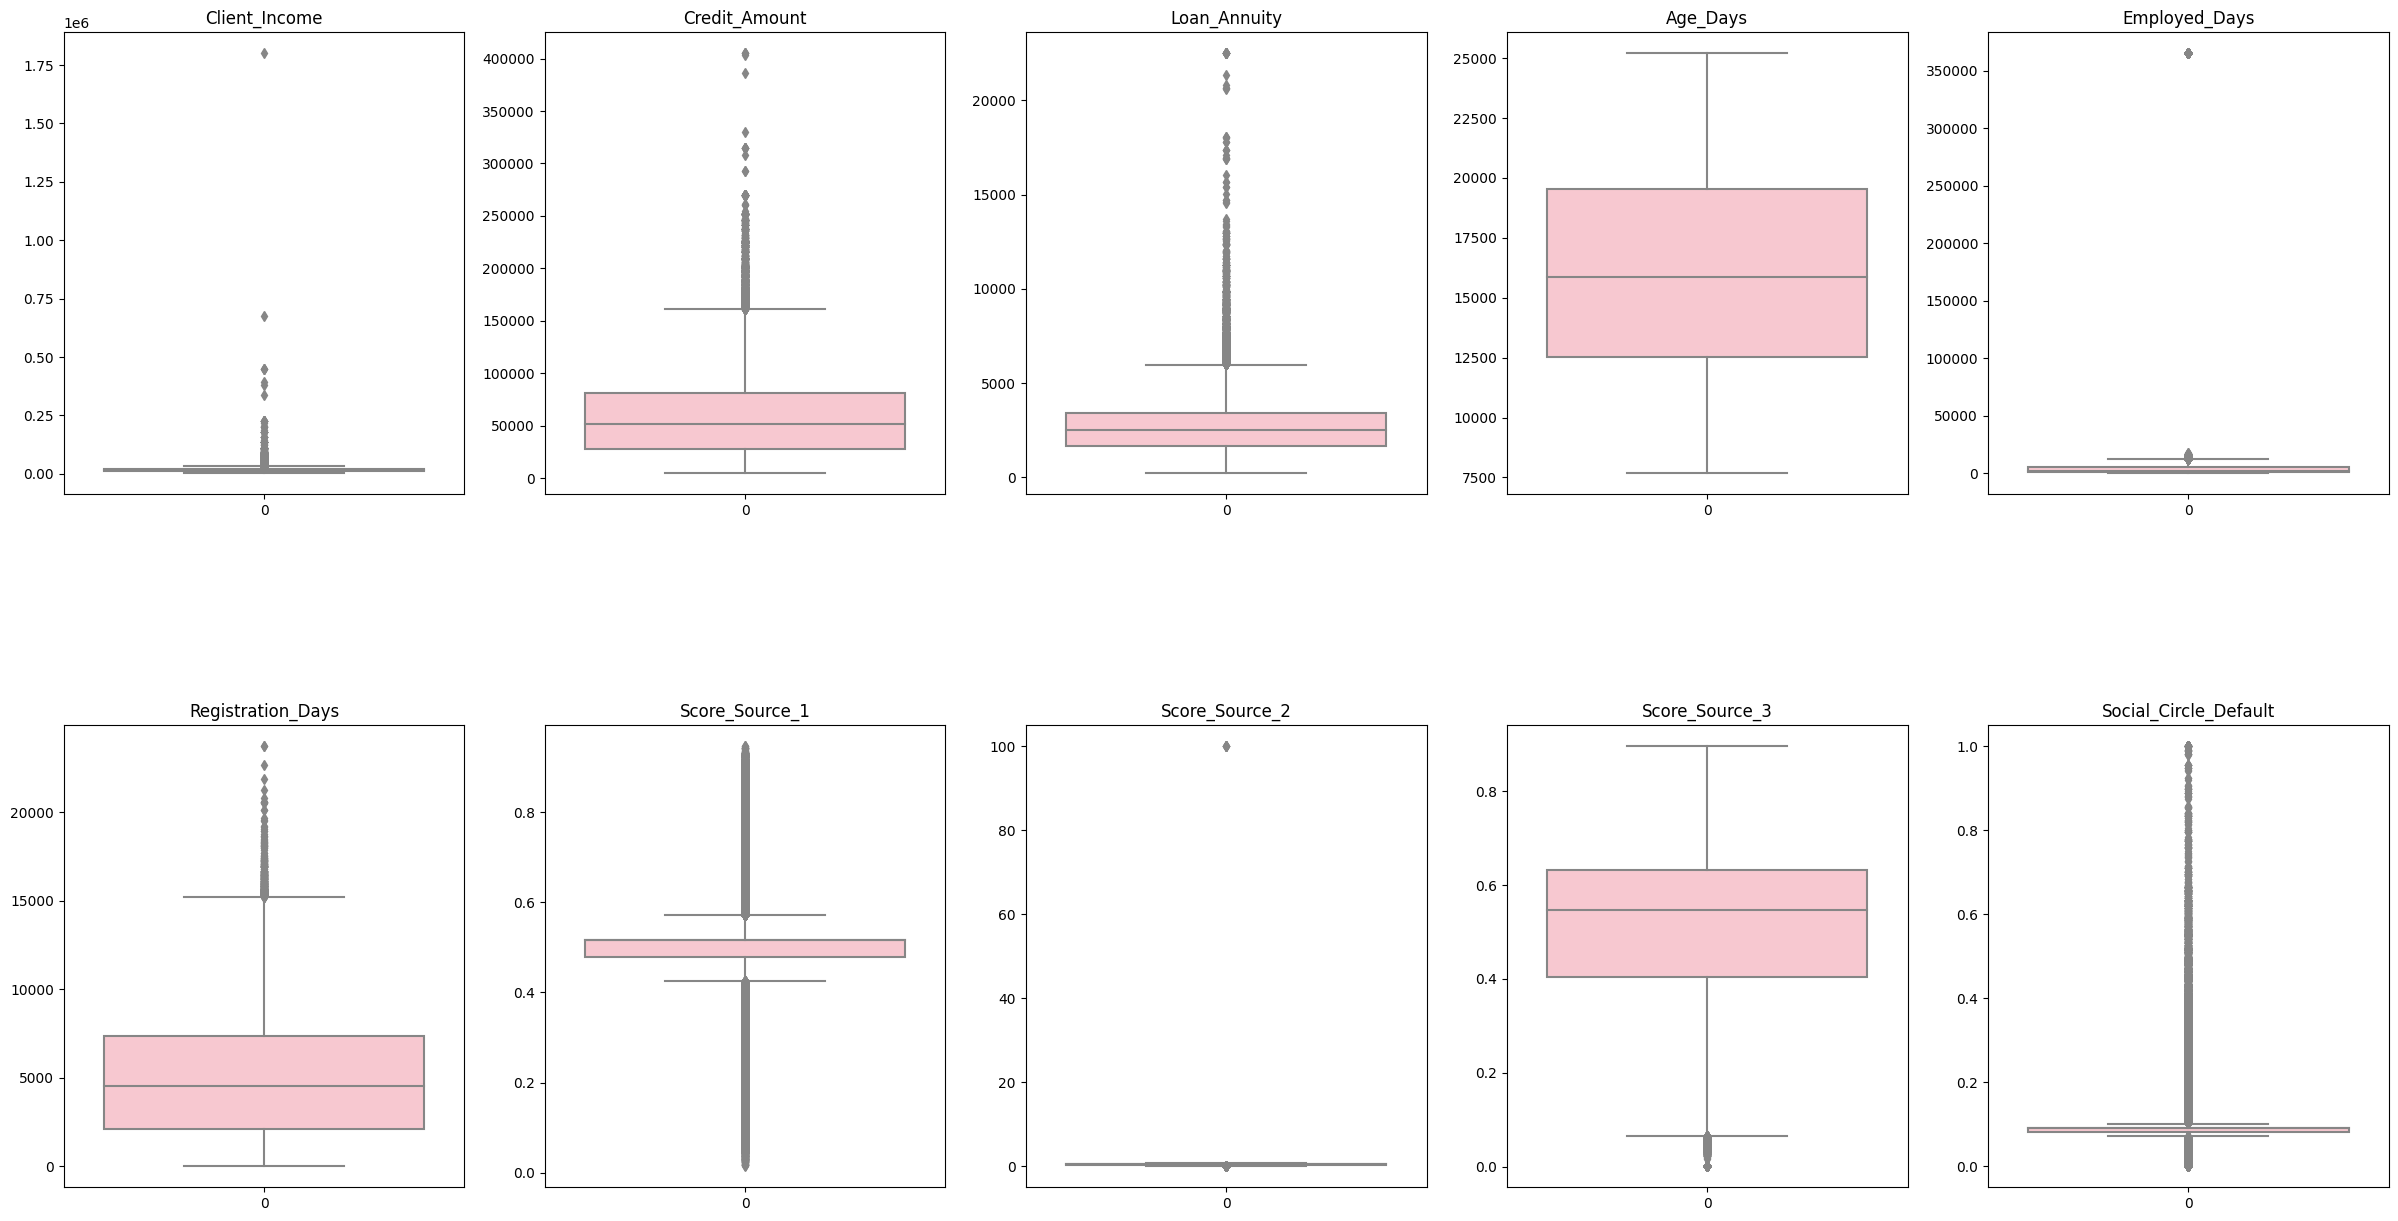

In [ ]:
# List of columns for visualization
columns_to_visualize = ['Client_Income', 'Credit_Amount', 'Loan_Annuity', 'Age_Days', 'Employed_Days',
                        'Registration_Days', 'Score_Source_1', 'Score_Source_2', 'Score_Source_3', 'Social_Circle_Default']

# Create side-by-side box plots in a single figure
num_plots = len(columns_to_visualize)
fig, axes = plt.subplots(2, 5, figsize=(30, 15))
fig.subplots_adjust(hspace=0.5)

# Custom color for the box plot (e.g., blue)
boxplot_color = 'pink'

for i, ax in enumerate(axes.flat):
    if i < num_plots:
        sns.boxplot(data=df[columns_to_visualize[i]], ax=ax, color=boxplot_color)
        ax.set_title(columns_to_visualize[i])

plt.show()

In [ ]:
# Define the find_outliers_iqr function
def find_outliers_iqr(df):
    # Compute the first quartile (Q1) and third quartile (Q3)
    Q1 = np.percentile(df, 25)
    Q3 = np.percentile(df, 75)

    # Compute the Interquartile Range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find the outliers and their indices
    outliers = [value for idx, value in enumerate(df) if value < lower_bound or value > upper_bound]
    outlier_indices = [idx for idx, value in enumerate(df) if value < lower_bound or value > upper_bound]

    # Create a DataFrame to hold outlier values and indices
    outliers_df = pd.DataFrame({'Outlier_Values': outliers, 'Outlier_Index': outlier_indices})

    return outliers_df

In [ ]:
# Call the find_outliers_iqr function with the 'Employed_Days' column to get the outliers
outliers_df = find_outliers_iqr(df['Employed_Days'])

# Print the number of outliers in the 'Employed_Days' column
num_outliers = len(outliers_df)
print("Number of outliers in 'Employed_Days':", num_outliers)

Number of outliers in 'Employed_Days': 21760


#### Outlier Handling

In [ ]:
# To handle the outliers we are using the capping technique

Q1 = np.percentile(df['Employed_Days'],25,interpolation='midpoint')
Q2 = np.percentile(df['Employed_Days'],50,interpolation='midpoint')
Q3 = np.percentile(df['Employed_Days'],75,interpolation='midpoint')

IQR = Q3 - Q1

up_lim = Q3 + 1.5*IQR
low_lim = Q1 - 1.5*IQR

<ipython-input-58-6cf1be229ce9>:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(df['Employed_Days'],25,interpolation='midpoint')
<ipython-input-58-6cf1be229ce9>:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q2 = np.percentile(df['Employed_Days'],50,interpolation='midpoint')
<ipython-input-58-6cf1be229ce9>:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy

In [ ]:
outliers = []

for x in df ['Employed_Days'] :
    if (x>up_lim) or (x<low_lim) :
        outliers.append(x)
df['Employed_Days'] = np.where(df['Employed_Days'] > up_lim, up_lim, np.where(df['Employed_Days'] < low_lim, low_lim,df['Employed_Days']))

## **Scaling**

In [ ]:
cols = ['Client_Income', 'Credit_Amount', 'Loan_Annuity', 'Age_Days', 'Employed_Days']

rs = RobustScaler()

for col in cols:
    df[col] = rs.fit_transform(df[[col]])

## **Feature Engineering**

In [ ]:
df['Vehicle_Owned'] = df['Car_Owned'] + df['Bike_Owned']
df['Family_Members'] = df['Child_Count'] + df['Client_Family_Members']


## Feature Reduction:

In [ ]:
columns_to_drop = ['Accompany_Client', 'Client_Housing_Type', 'Population_Region_Relative', 'Registration_Days', 'ID_Days',
'Mobile_Tag', 'Homephone_Tag','Cleint_City_Rating', 'Client_Permanent_Match_Tag','Client_Contact_Work_Tag',
'Workphone_Working','Score_Source_1', 'Score_Source_2', 'Score_Source_3', 'Social_Circle_Default','Phone_Change', 'Credit_Bureau',
                   'Car_Owned', 'Bike_Owned', 'Child_Count', 'Client_Family_Members']

df = df.drop(columns=columns_to_drop)

In [ ]:
df.shape

(121856, 17)

In [ ]:
df.head()

,Client_Income,Active_Loan,House_Own,Credit_Amount,Loan_Annuity,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Age_Days,Employed_Days,Client_Occupation,Type_Organization,Default,Vehicle_Owned,Family_Members
0,-0.90,1.0,0.0,0.182165,0.521546,1,5.0,1,1,0,-0.268914,-0.278996,14,42,0,0.0,2.0
1,0.60,1.0,1.0,-0.677304,-0.402799,6,0.0,1,1,0,-0.239761,0.414425,17,11,0,1.0,2.0
2,0.35,1.0,0.0,0.151028,0.156150,6,1.0,4,1,0,0.133959,0.634411,13,42,0,0.0,3.0
3,0.10,1.0,1.0,0.045122,-0.130256,5,5.0,1,1,0,1.044795,2.198395,19,57,0,0.0,2.0
4,2.10,1.0,0.0,1.545038,0.597398,1,5.0,1,0,0,-0.637372,0.153968,8,5,0,1.0,6.0


In [ ]:
df.columns

Index(['Client_Income', 'Active_Loan', 'House_Own', 'Credit_Amount',
       'Loan_Annuity', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Age_Days', 'Employed_Days', 'Client_Occupation', 'Type_Organization',
       'Default', 'Vehicle_Owned', 'Family_Members'],
      dtype='object')

In [ ]:
 #Split the data into features and target variable
x = df.drop("Default", axis=1)  # Features
y = df["Default"]  # target

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train,x_test, y_train, y_test = train_test_split(x,y, random_state= 42, test_size= 0.40)

In [ ]:
x_test,x_val,y_test, y_val = train_test_split(x_test,y_test, random_state= 42, test_size= 0.50)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:

# Define your parameter grid for RandomizedSearchCV
param_dist ={'n_estimators': [10,50,100,200,500],
             'max_depth': [5,10,50,100, None],
             'criterion' : ["gini", "entropy"]}
# Create a Random Forest classifier
rf = RandomForestClassifier()

# Create a RandomizedSearchCV object
rf_random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1
)

# Fit the RandomizedSearchCV object to your data
rf_random_search.fit(x_train, y_train)

# Define a function to print the results
def print_results_random(results):
    print('Best Params: {}\n'.format(results.best_params_))

    mean_scores = results.cv_results_['mean_test_score']
    std_scores = results.cv_results_['std_test_score']

    for mean_score, std_score, params in zip(mean_scores, std_scores, results.cv_results_['params']):
        print('{} +/- {} for {}'.format(round(mean_score, 3), round(std_score, 3), params))

# Print the results
print_results_random(rf_random_search)

Best Params: {'n_estimators': 200, 'max_depth': 50, 'criterion': 'gini'}

0.919 +/- 0.0 for {'n_estimators': 500, 'max_depth': 10, 'criterion': 'gini'}
0.926 +/- 0.001 for {'n_estimators': 50, 'max_depth': None, 'criterion': 'gini'}
0.923 +/- 0.0 for {'n_estimators': 10, 'max_depth': 100, 'criterion': 'entropy'}
0.919 +/- 0.0 for {'n_estimators': 50, 'max_depth': 5, 'criterion': 'entropy'}
0.919 +/- 0.0 for {'n_estimators': 200, 'max_depth': 10, 'criterion': 'gini'}
0.926 +/- 0.0 for {'n_estimators': 200, 'max_depth': 50, 'criterion': 'gini'}
0.919 +/- 0.0 for {'n_estimators': 500, 'max_depth': 10, 'criterion': 'entropy'}
0.919 +/- 0.0 for {'n_estimators': 100, 'max_depth': 10, 'criterion': 'gini'}
0.919 +/- 0.0 for {'n_estimators': 200, 'max_depth': 5, 'criterion': 'gini'}
0.919 +/- 0.0 for {'n_estimators': 200, 'max_depth': 5, 'criterion': 'entropy'}


In [ ]:
rf1 = RandomForestClassifier(n_estimators=100, max_depth=100, criterion='gini')
rf1.fit(x_train,y_train)

RandomForestClassifier(max_depth=100)

In [ ]:
y_pred_rf1=rf1.predict(x_val)

In [ ]:
rf2 = RandomForestClassifier(n_estimators=500, max_depth=50, criterion='entropy')
rf2.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=500)

In [ ]:
rf3 = RandomForestClassifier(n_estimators=50, max_depth=10, criterion='gini')
rf3.fit(x_train,y_train)

RandomForestClassifier(max_depth=10, n_estimators=50)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score

for mdl in [rf1, rf2, rf3]:
    y_pred = mdl.predict(x_val)
    accuracy = round(accuracy_score(y_val, y_pred), 2)  # Use y_pred instead of constant 3
    precision = round(precision_score(y_val, y_pred), 2)  # Use y_pred instead of constant 3
    print('Max Depth: {} # of Estimators: {} Criterion: {} -- Accuracy: {} / Precision: {}'.format(mdl.max_depth, mdl.n_estimators, mdl.criterion, accuracy, precision))

Max Depth: 100 # of Estimators: 100 Criterion: gini -- Accuracy: 0.93 / Precision: 0.99
Max Depth: 50 # of Estimators: 500 Criterion: entropy -- Accuracy: 0.93 / Precision: 0.99
Max Depth: 10 # of Estimators: 50 Criterion: gini -- Accuracy: 0.92 / Precision: 1.0


In [ ]:
rf2_final = RandomForestClassifier(n_estimators=500, max_depth=50, criterion='entropy')
rf2_final.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=500)

In [ ]:
y_pred_rf2=rf2_final.predict(x_test)

In [ ]:
print('Accuracy=',accuracy_score(y_test,y_pred_rf2))
print('Precision=',precision_score(y_test,y_pred_rf2,average='weighted'))
print('Recall=',recall_score(y_test,y_pred_rf2,average='weighted'))
print('F1 Score',f1_score(y_test,y_pred_rf2,average='weighted'))

Accuracy= 0.9262648229453039
Precision= 0.9304828678497525
Recall= 0.9262648229453039
F1 Score 0.896956135695233


Accuracy: The accuracy of the model is approximately 0.926, which means that around 92.6% of the predictions made by the model were correct. Accuracy is a measure of overall correctness and can be misleading if the dataset is imbalanced.

Precision: Precision is approximately 0.930, indicating that out of all the instances that the model predicted as positive, about 93% of them were actually true positives. Precision is a measure of how many of the predicted positive cases were actually correct.

Recall: Recall is also approximately 0.926, which suggests that the model was able to correctly identify around 92.6% of the actual positive cases in the dataset. Recall is a measure of how many actual positive cases the model was able to capture.

F1 Score: The F1 score is approximately 0.897, which is the harmonic mean of precision and recall. It balances both precision and recall and is especially useful when dealing with imbalanced datasets. A higher F1 score indicates a better balance between precision and recall.

The model seems to be performing well with high accuracy, precision, and recall scores.The high precision and recall are positive signs that the model is able to identify and differentiate the minority class instances fairly well.

In [ ]:
print(confusion_matrix(y_test,y_pred_rf2))

[[22398     3]
 [ 1794   176]]


True Positives (TP): 176
True Negatives (TN): 22398
False Positives (FP): 3
False Negatives (FN): 1794

The confusion matrix and calculated metrics indicate that the model has a high number of true negatives (22398) and true positives (176), which contribute to its high accuracy of 92.6%. However, when looking at precision, recall, and the F1 score, the results are quite different due to the class imbalance: